In [2]:
import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.io

%matplotlib inline
imginfo = lambda img: print(type(img), img.dtype, img.shape)

mat = scipy.io.loadmat('data/data_rfa_forPython.mat')

We have 15 sessions (rat, session). For first (rat, session) pair we see 252 trials. For first trial we have spikes_cue and spikes_mov of shape (11, 152) of uint16 dtype - the indices of spikes for each neuron.


In [3]:
print(type(mat)) # dict
print(mat.keys())

imginfo(mat["data_cfa"]) # (1, sessions)
sessions = mat["data_cfa"][0]
print("Number of sessions:", len(sessions))

<class 'dict'>
dict_keys(['__header__', '__version__', '__globals__', 'data_cfa', '__function_workspace__'])
<class 'numpy.ndarray'> [('rat', 'O'), ('session', 'O'), ('trials', 'O'), ('time', 'O'), ('n_neurons', 'O')] (1, 15)
Number of sessions: 15


In [4]:
session_id = 0
print(sessions[session_id]['rat'])
print(sessions[session_id]['session'])
imginfo(sessions[session_id]['trials'])

[[10]]
[[1]]
<class 'numpy.ndarray'> [('trial', 'O'), ('RT', 'O'), ('outcome', 'O'), ('type', 'O'), ('press_to_release', 'O'), ('spikes_cue', 'O'), ('spikes_mov', 'O')] (252, 1)


In [5]:
trial_id = 0
print(sessions[session_id]['trials'][trial_id, 0]['trial'])
print(sessions[session_id]['trials'][trial_id, 0]['RT'])
imginfo(sessions[session_id]['trials'][trial_id, 0]['outcome']) # not readable!
imginfo(sessions[session_id]['trials'][trial_id, 0]['type']) # not readable!
imginfo(sessions[session_id]['trials'][trial_id, 0]['press_to_release'])
print(sessions[session_id]['trials'][trial_id, 0]['press_to_release'])

imginfo(sessions[session_id]['trials'][trial_id, 0]['spikes_cue'])
imginfo(sessions[session_id]['trials'][trial_id, 0]['spikes_mov'])


[[1]]
[[0.06]]
<class 'scipy.io.matlab._mio5_params.MatlabOpaque'> [('s0', 'O'), ('s1', 'O'), ('s2', 'O'), ('arr', 'O')] (1,)
<class 'scipy.io.matlab._mio5_params.MatlabOpaque'> [('s0', 'O'), ('s1', 'O'), ('s2', 'O'), ('arr', 'O')] (1,)
<class 'numpy.ndarray'> float64 (1, 1)
[[0.06]]
<class 'numpy.ndarray'> object (11, 1)
<class 'numpy.ndarray'> object (11, 1)


## Neurons in rats

Text(0, 0.5, 'num of neurons')

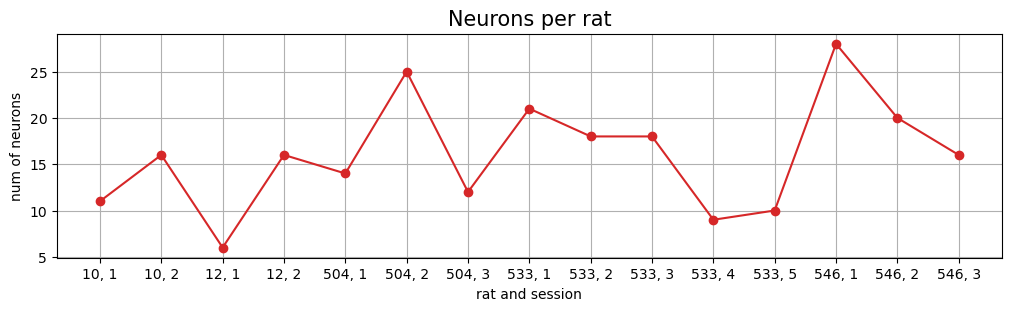

In [6]:
def get_rat_ids(sessions):
    # rats[entry] = (rat, session, trials, time, n_neurons)
    rat_ids = [entry['rat'][0, 0] for entry in sessions]
    return sorted(set(rat_ids))

def get_rat_sessions(sessions, rat_ids):
    res = []
    # select rat, count entries for this rat
    for rat in rat_ids:
        sessions_per_rat = []
        for entry in sessions:
            if entry['rat'][0, 0] == rat:
                sessions_per_rat.append(entry['session'][0, 0])
        res.append(sessions_per_rat)
    return res


session_str = []
neuron_count = []
for entry_idx in range(len(sessions)):
    rat, session, neurons = sessions[entry_idx]['rat'][0, 0], sessions[entry_idx]['session'][0, 0], sessions[entry_idx]['n_neurons'][0, 0]
    session_str.append(f"{rat}, {session}")
    neuron_count.append(neurons)

fig, axs = plt.subplots(1, 1, layout='constrained', figsize=(10,3))

axs.set_title('Neurons per rat',fontsize=15)
axs.plot(session_str, neuron_count, 'o-', color='tab:red', label="rat #1")
axs.grid(True)
axs.set_xlabel('rat and session',  fontsize=10)
axs.set_ylabel('num of neurons',  fontsize=10)
#axs.legend(fontsize=10)

#fig.savefig("fig.pdf")

Text(0, 0.5, 'num of neurons')

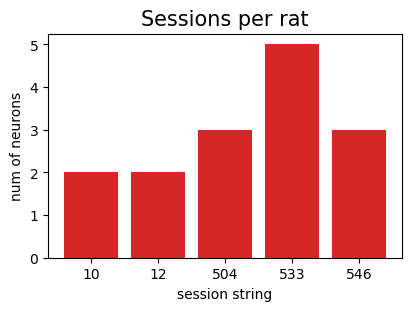

In [7]:
rat_ids = get_rat_ids(sessions)
rat_session_count = [len(sess_list)  for sess_list in get_rat_sessions(sessions, rat_ids)]

rat_ids = list(map(str, rat_ids))

fig, axs = plt.subplots(1, 1, layout='constrained', figsize=(4,3))

axs.set_title('Sessions per rat',fontsize=15)
axs.bar(rat_ids, rat_session_count, color='tab:red')
axs.set_xlabel('session string',  fontsize=10)
axs.set_ylabel('num of neurons',  fontsize=10)

## Reaction time

In trial 0 reaction_time = press_to_release, meaning the mouse released before vibration. Let's count the early / not early trials.

In [8]:
total_trials = len(sessions[session_id]['trials'])
outcome = np.zeros((total_trials), dtype=int) # 0 - early, 1 - correct, 2 - late
RT = np.zeros((total_trials))
press_to_release = np.zeros((total_trials))

# convert RT and press_to_release from matlab to numpy
for trial_id in range(len(sessions[session_id]['trials'])):
    RT[trial_id] = sessions[session_id]['trials'][trial_id, 0]['RT'][0, 0]
    press_to_release[trial_id] = sessions[session_id]['trials'][trial_id, 0]['press_to_release'][0, 0]

# calculate if release was early, correct or later
diff = press_to_release - RT
equal = np.isclose(diff, 0)
outcome[equal] = 0
outcome[~equal & (RT < 1.0)] = 1
outcome[~equal & (RT > 1.0)] = 2
print("early:", np.sum(outcome == 0))
print("reaction < 1 sec:", np.sum(outcome == 1))
print("late:", np.sum(outcome == 2))
print("total:", total_trials)


early: 156
reaction < 1 sec: 84
late: 12
total: 252


Text(0, 0.5, 'count')

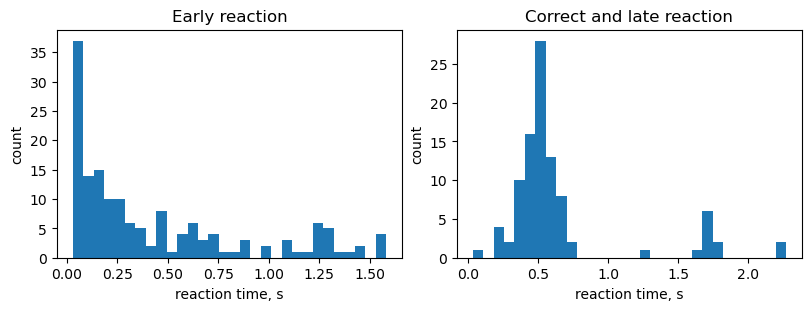

In [9]:
early_RT = RT[outcome == 0]
not_early_RT = RT[~(outcome == 0)]

fig, axs = plt.subplots(1, 2, layout='constrained', figsize=(8,3))


axs[0].set_title('Early reaction')
axs[0].hist(early_RT, bins=30)
axs[0].set_xlabel('reaction time, s',  fontsize=10)
axs[0].set_ylabel('count',  fontsize=10)

axs[1].set_title('Correct and late reaction')
axs[1].hist(not_early_RT, bins=30)
axs[1].set_xlabel('reaction time, s',  fontsize=10)
axs[1].set_ylabel('count',  fontsize=10)

#fig.savefig("fig.png")

Let's take a correct outcome and plot spike indices.

In [10]:
for i in range(0, len(outcome), 5):
    print(i, outcome[i], RT[i])

0 0 0.060000000000002274
5 0 0.060000000000002274
10 0 0.0700000000000216
15 0 0.6199999999998909
20 0 0.05999999999994543
25 0 0.37000000000011823
30 0 0.2300000000000182
35 0 0.49000000000023647
40 0 0.28000000000002956
45 0 0.9599999999999795
50 0 0.17000000000007276
55 0 0.22000000000002728
60 0 0.08000000000004093
65 0 0.12999999999999545
70 0 0.18000000000006366
75 0 0.03999999999996362
80 0 0.05999999999994543
85 0 1.240000000000009
90 0 0.14000000000010004
95 0 0.060000000000172804
100 0 0.2599999999999909
105 0 1.1600000000000819
110 0 0.8100000000001728
115 0 0.5399999999999636
120 0 1.4600000000000364
125 0 0.4900000000000091
130 0 1.2999999999999545
135 0 1.240000000000009
140 0 0.5700000000001637
145 0 0.05999999999994543
150 0 1.569999999999709
155 0 0.7799999999997453
160 1 0.4799999999999045
165 1 0.5100000000002183
170 1 0.5
175 1 0.3300000000001546
180 1 0.5100000000002183
185 1 0.5900000000001455
190 1 0.3200000000001637
195 1 0.5799999999999272
200 1 0.5399999999999

In [11]:
trial_id = 165
neuron_id = 0
imginfo(sessions[session_id]['trials'][trial_id, 0]['spikes_cue'][neuron_id, 0])
print(sessions[session_id]['trials'][trial_id, 0]['spikes_cue'][neuron_id, 0][:5])
print(sessions[session_id]['trials'][trial_id, 0]['spikes_mov'][neuron_id, 0][:5])

<class 'numpy.ndarray'> uint16 (226, 1)
[[ 9]
 [25]
 [61]
 [75]
 [77]]
[[  3]
 [ 55]
 [ 91]
 [120]
 [125]]


## What is time array?

A: It is independent of trial. Time points are uniformly distributed from a negative point (like -3) to a positive point (like +2).

In [12]:
imginfo(sessions[session_id]['time'])
time = sessions[session_id]['time'][0]
print(time)
print(time[1] - time[0], time[2] - time[1], time[3] - time[2], time[4] - time[3])

<class 'numpy.ndarray'> float64 (1, 4885)
[-3.00032  -2.999296 -2.998272 ...  1.998848  1.999872  2.000896]
0.0010239999999996918 0.001024000000000136 0.001024000000000136 0.0010239999999996918


Compare difference of spikes_cue and spikes mov, and reaction time (difference of cue and movement).

In [13]:
cue = sessions[session_id]['trials'][trial_id, 0]['spikes_cue'][neuron_id, 0][:, 0]
mov = sessions[session_id]['trials'][trial_id, 0]['spikes_mov'][neuron_id, 0][:, 0]
print("RT {:.2f} PR {:.2f} cue_0 - mov_0 {:.2f}".format(
    RT[trial_id], press_to_release[trial_id], time[cue[0]] - time[mov[0]])
)
imginfo(cue)
imginfo(mov)

RT 0.51 PR 1.11 cue_0 - mov_0 0.01
<class 'numpy.ndarray'> uint16 (226,)
<class 'numpy.ndarray'> uint16 (216,)


**Conclusion:** Shapes are different, difference between same indices not close to reaction time. The arrays do not represent identical firing events.

## Plot spikes as histogram

Same mouse, same neuron, different trial.

Text(0, 0.5, 'count')

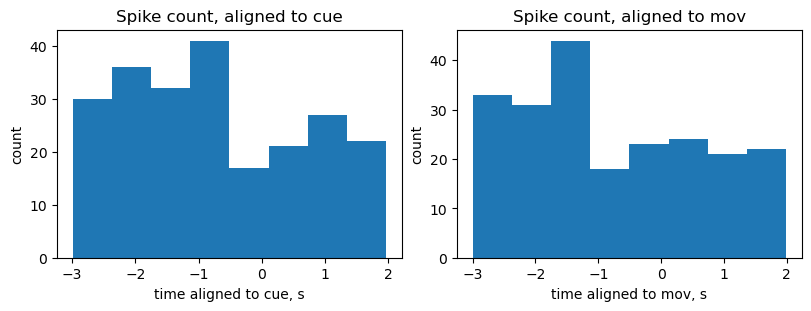

In [14]:
fig, axs = plt.subplots(1, 2, layout='constrained', figsize=(8,3))

axs[0].set_title('Spike count, aligned to cue')
axs[0].hist(time[cue], bins=8)
axs[0].set_xlabel('time aligned to cue, s',  fontsize=10)
axs[0].set_ylabel('count',  fontsize=10)

axs[1].set_title('Spike count, aligned to mov')
axs[1].hist(time[mov], bins=8)
axs[1].set_xlabel('time aligned to mov, s',  fontsize=10)
axs[1].set_ylabel('count',  fontsize=10)

interactive(children=(IntSlider(value=0, description='w', layout=Layout(width='70%'), max=251, step=20), Outpu…

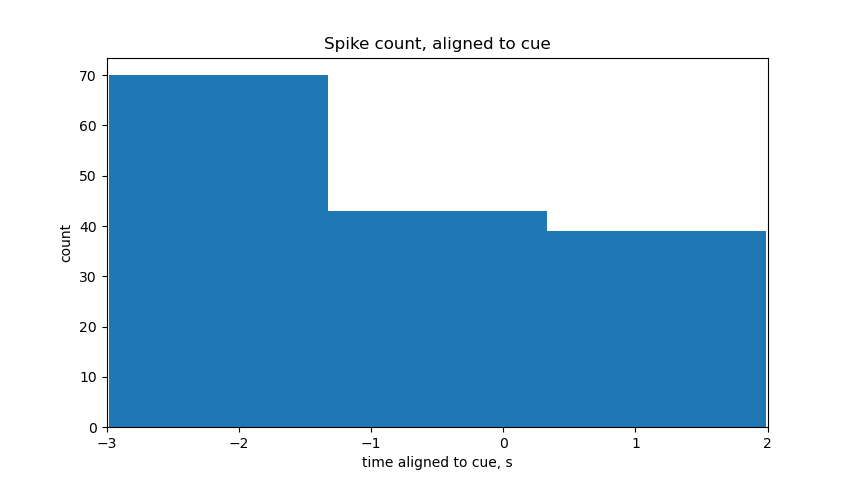

In [15]:
%matplotlib widget
from ipywidgets import widgets, Layout, interact

def update(w: int):
    global fig, ax
    print("trial", w)
    
    cue = sessions[session_id]['trials'][w, 0]['spikes_cue'][neuron_id, 0][:, 0] - 1
    mov = sessions[session_id]['trials'][w, 0]['spikes_mov'][neuron_id, 0][:, 0] - 1

    ax.clear()
    ax.set_title('Spike count, aligned to cue')
    ax.hist(time[cue], bins=3)
    ax.set_xlabel('time aligned to cue, s',  fontsize=10)
    ax.set_ylabel('count',  fontsize=10)
    ax.set_xlim((-3, 2))
    
    fig.canvas.draw_idle()

image_width, image_height = int(1280/3*2), int(720/3*2) # 1280 x 720
dpi = 100
figsize = (image_width / dpi, image_height / dpi)
fig, ax = plt.subplots(1, figsize=figsize, dpi=dpi)
ax.set_axis_off()

slider_w = widgets.IntSlider(
    min=0, max=len(sessions[session_id]['trials'])-1, step=20, value=0, layout=Layout(width="70%")
)
interact(update, w=slider_w)
pass


Spikes indices start from 1!